# Image Augmentation in Keras
Data augmentation is a strategy used to increase the amount of data by using techniques like cropping, padding, flipping, etc. Data augmentation makes the model more robust to slight variations, and hence prevents the model from overfitting. ImageDataGenerator generates batches of tensor image data with real-time data augmentation. The output images generated by the generator will have the same output dimensions as the input images.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(2020)

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPool2D, Lambda
import keras
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback
from PIL import Image
import os
from os import listdir
from os.path import splitext
from imgaug import augmenters as iaa
from imgaug import parameters as iap

from keras.preprocessing.image import ImageDataGenerator
#!pip install livelossplot
#!pip install shapely
#!pip install imgaug

## Data preparation

In [3]:
# Loading of tensors X i y
X = np.load('X_vis_binary_class.npy')
y = np.load('y_vis_binary_class.npy')
print(X.shape, y.shape)

(7988, 128, 128, 3) (7988,)


In [4]:
# Split X i y to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2019)
img_rows, img_cols, channels = 128,128, 3
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Conversion to float
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

(6390, 128, 128, 3) (6390,)
(1598, 128, 128, 3) (1598,)


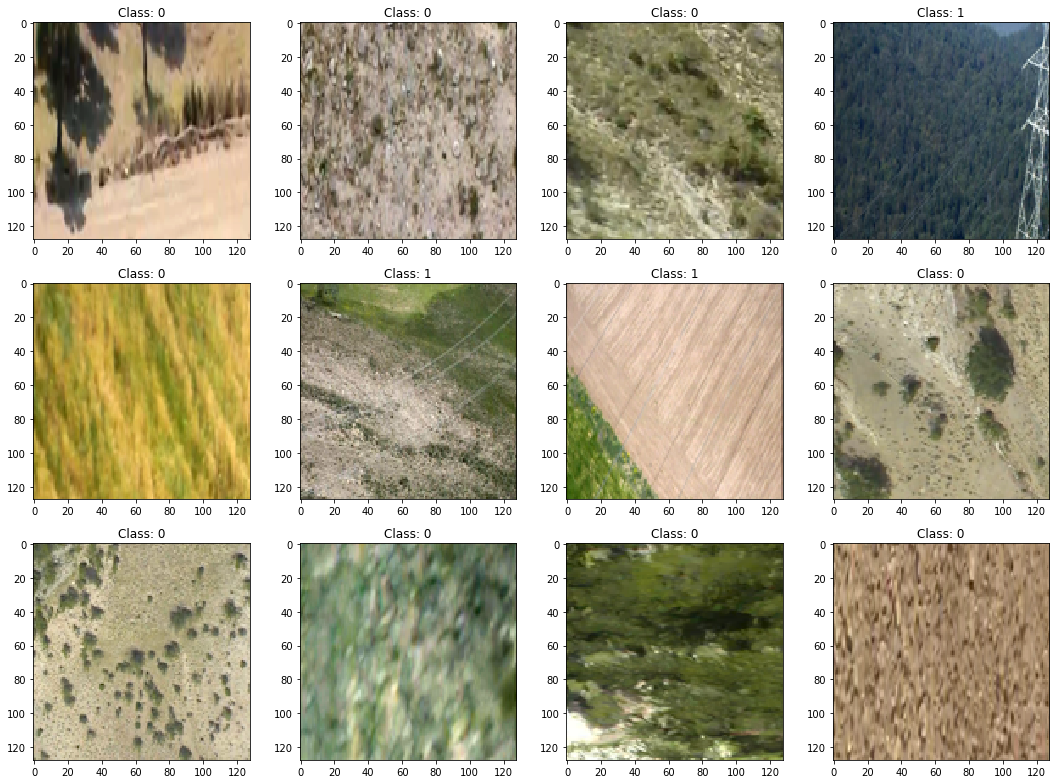

In [5]:
# Image visualization
plt.figure(figsize=(15,11))
for idx in range(12):
    plt.subplot(3,4,idx+1)
    img = X_train[idx]
    img = np.float32(np.interp(X_train[idx], (X_train[idx].min(), X_train[idx].max()), (0, 1)))
    plt.imshow(np.float32(img))
    plt.title('Class: {}'.format(y_train[idx]))# wyjściowa klasa 
plt.tight_layout()

# Augmentations
## Feature standarization
It is a process which standardizes pixel values across the entire dataset. Feature standardization mirrors the type of standardization often performed for each column in a tabular dataset.

We can perform feature standardization by setting the featurewise_center and featurewise_std_normalization arguments on the ImageDataGenerator class. 
These are in fact set to True by default and creating an instance of ImageDataGenerator with no arguments will have the same effect.

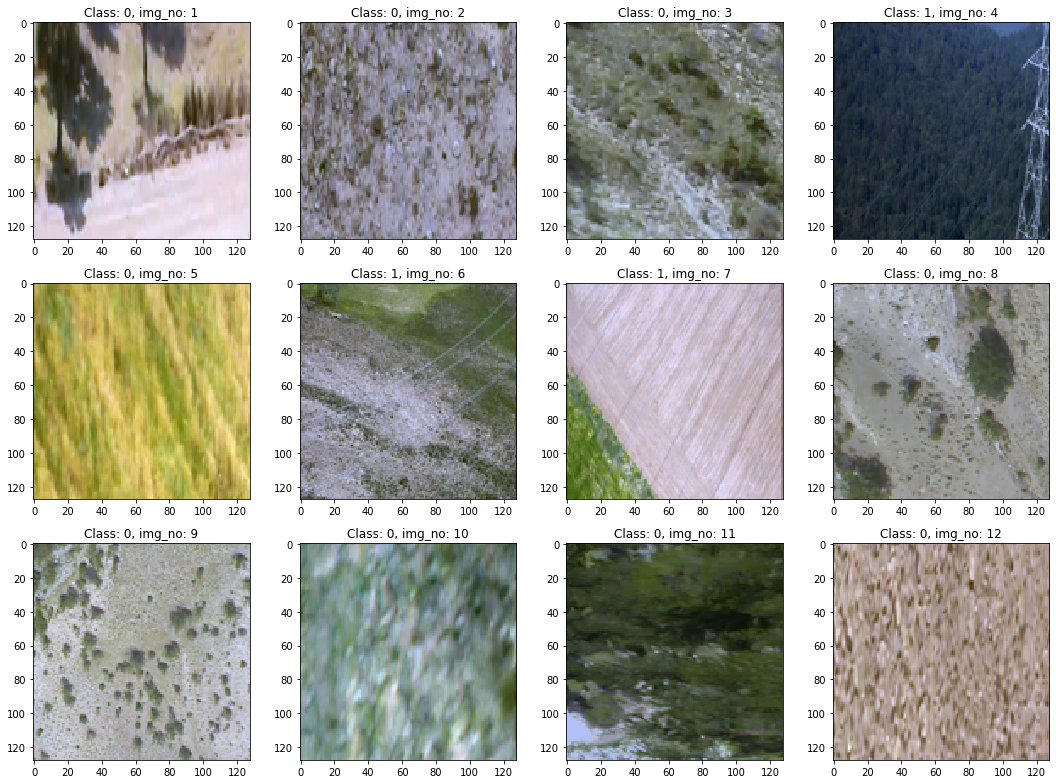

In [6]:
# Define data preparation
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# Fit parameters from data
datagen.fit(X_train)

# Configure batch size and retrive one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size = 12,shuffle=False):
    # create a grid of 3x4 images
    plt.figure(figsize=(15,11))
    for idx in range(0,12):
        plt.subplot(3,4,idx+1)
        img = np.uint8(np.interp(X_batch[idx], (X_batch[idx].min(), X_batch[idx].max()), (0, 255)))
        plt.imshow(img)
        plt.title('Class: {}, img_no: {}'.format(y_batch[idx],(idx+1)))
    plt.tight_layout()
    break

# Function to augment images

In [7]:
def augmentation(datagen):
    # Fit parameters from data
    datagen.fit(X_train)

    # Configure batch size and retrive one batch of images
    for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size = 12,shuffle=False):
        # create a grid of 3x4 images
        plt.figure(figsize=(15,11))
        for idx in range(0,12):
            plt.subplot(3,4,idx+1)
            img = np.uint8(np.interp(X_batch[idx], (X_batch[idx].min(), X_batch[idx].max()), (0, 255)))
            plt.imshow(img)
            plt.title('Class: {}, img_no: {}'.format(y_batch[idx],(idx+1)))
        plt.tight_layout()
        break

## ZCA Whitening
A whitening transform of an image is a linear algebra operation that reduces the redundancy in the matrix of pixel images. Less redundancy in the image is intended to better highlight the structures and features in the image to the learning algorithm. Typically, image whitening is performed using the Principal Component Analysis (PCA) technique. More recently, an alternative called ZCA shows better results and results in transformed images that keeps all of the original dimensions and unlike PCA, resulting transformed images still look like their originals.

In [ ]:
# Define data preparation
datagen = ImageDataGenerator(zca_whitening=True)
augmentation(datagen)

## Random Rotations
Sometimes images in data may have varying and different rotations in the scene. We can train our model to better handle rotations of images by artificially and randomly rotating images from your dataset during training.
Inmy example images have been rotated left and right up to a limit of 90 degrees.

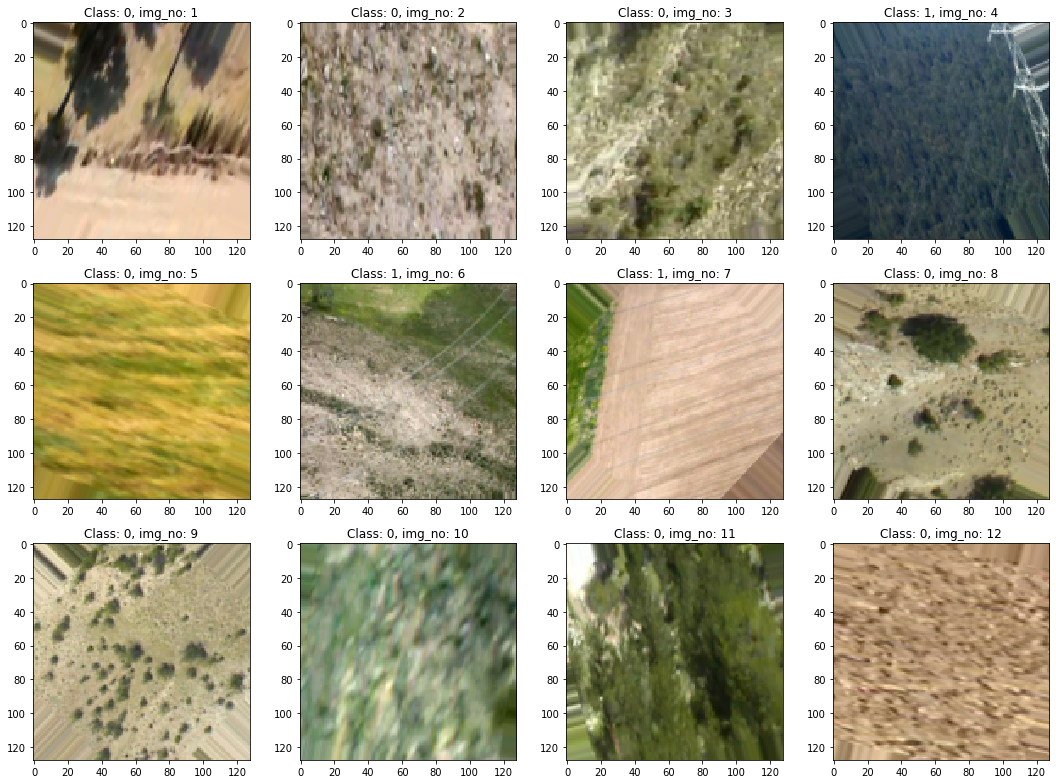

In [8]:
# Define data preparation
datagen = ImageDataGenerator(rotation_range=90)
augmentation(datagen)

## Random Shifts
Objects in images may not be centered in the frame. They may be off-center in a variety of different ways. We can train our deep learning network to expect and currently handle off-center objects by artificially creating shifted versions of our training data. Keras supports separate horizontal and vertical random shifting of training data by the width_shift_range and height_shift_range arguments.  In this example we create shifted versions of the digits.

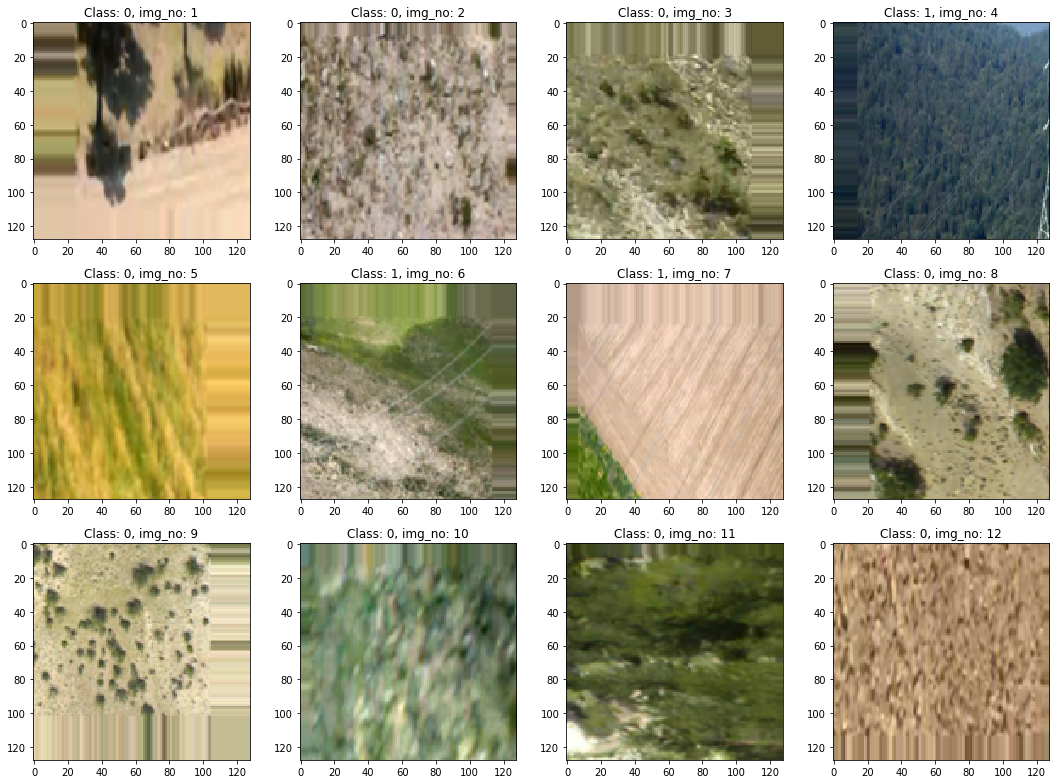

In [9]:
# Define data preparation
datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2) #0.2 > 20% of image can be shifted
augmentation(datagen)

## Random Flips
Another augmentation to our image data that can improve performance on large and complex problems is  random flips of images in our training data.
Keras supports random flipping along both the vertical and horizontal axes using the vertical_flip and horizontal_flip arguments.

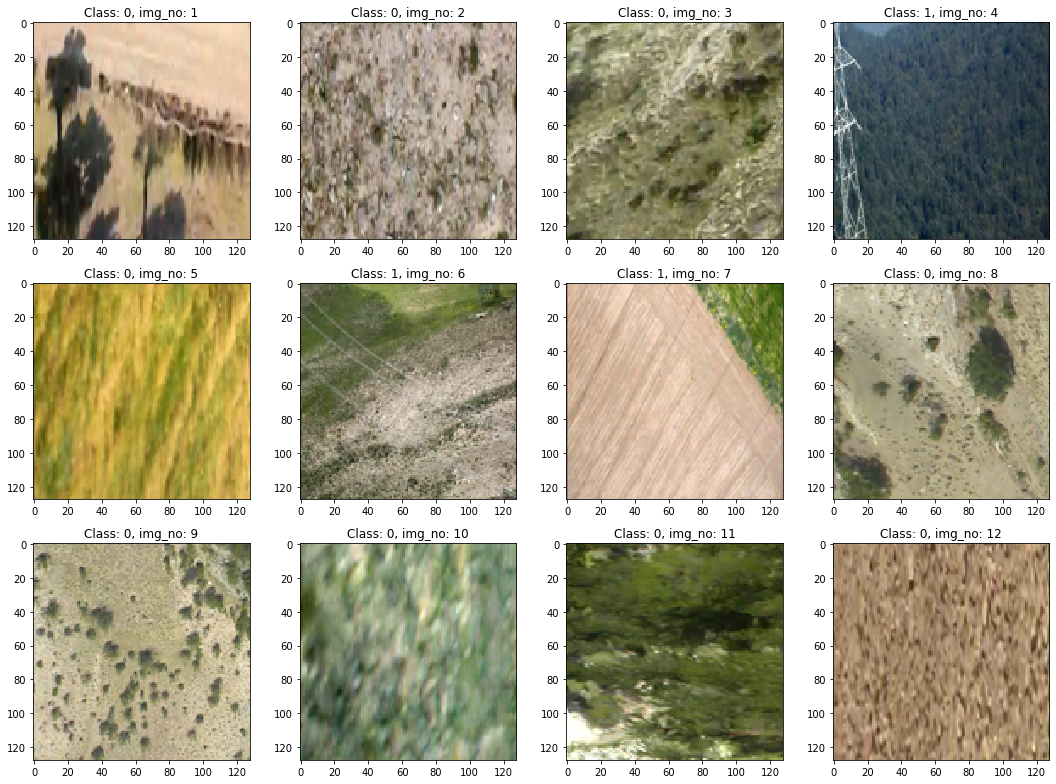

In [10]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
augmentation(datagen)

## Random image zoom
A zoom augmentation randomly zooms the image in and either adds new pixel values around the image or interpolates pixel values respectively.
Image zooming can be configured by the zoom_range argument to the ImageDataGenerator constructor. You can specify the percentage of the zoom as a single float or a range as an array or tuple.

If a float is specified, then the range for the zoom will be [1-value, 1+value]. For example, if you specify 0.3, then the range will be [0.7, 1.3], or between 70% (zoom in) and 130% (zoom out).

The zoom amount is uniformly randomly sampled from the zoom region for each dimension (width, height) separately.

The zoom may not feel intuitive. Note that zoom values less than 1.0 will zoom the image in, e.g. [0.5,0.5] makes the object in the image 50% larger or closer, and values larger than 1.0 will zoom the image out by 50%, e.g. [1.5, 1.5] makes the object in the image smaller or further away. A zoom of [1.0,1.0] has no effect.

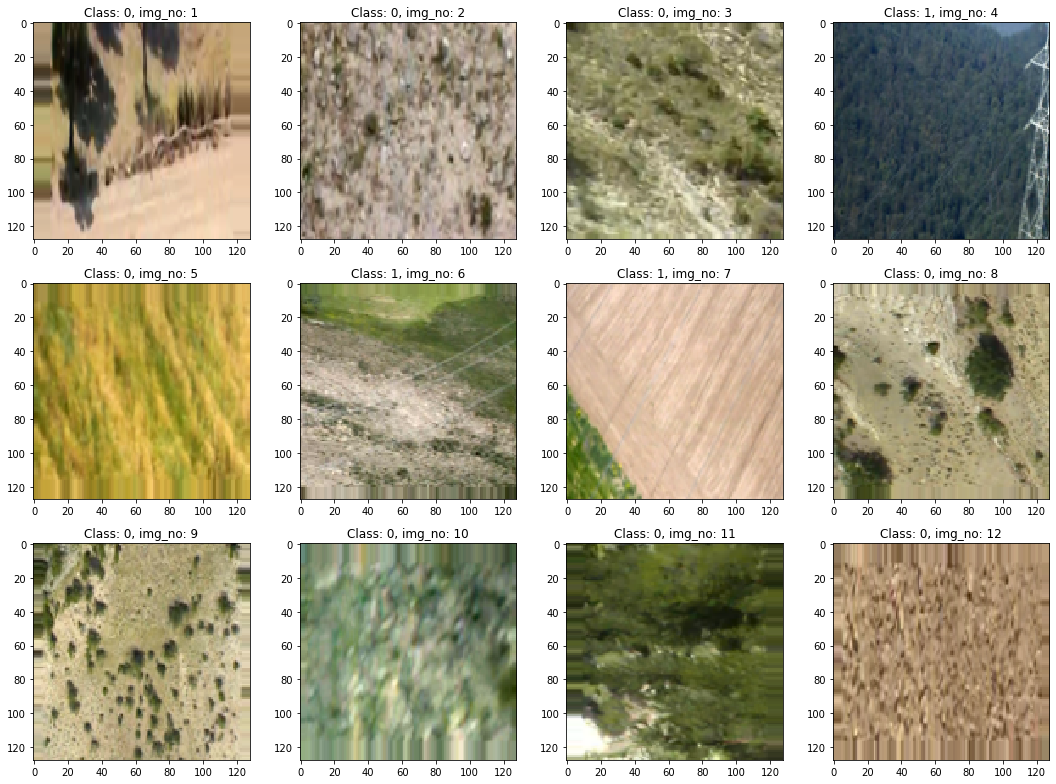

In [11]:
datagen = ImageDataGenerator(zoom_range=0.2)
augmentation(datagen)

## Random Brightness Augmentation
The brightness of the image can be augmented by either randomly darkening images, brightening images, or both. The intent is to allow a model to generalize across images trained on different lighting levels.

This can be achieved by specifying the brightness_range argument to the ImageDataGenerator() constructor that specifies min and max range as a float representing a percentage for selecting a brightening amount.

Values less than 1.0 darken the image, e.g. [0.5, 1.0], whereas values larger than 1.0 brighten the image, e.g. [1.0, 1.5], where 1.0 has no effect on brightness.

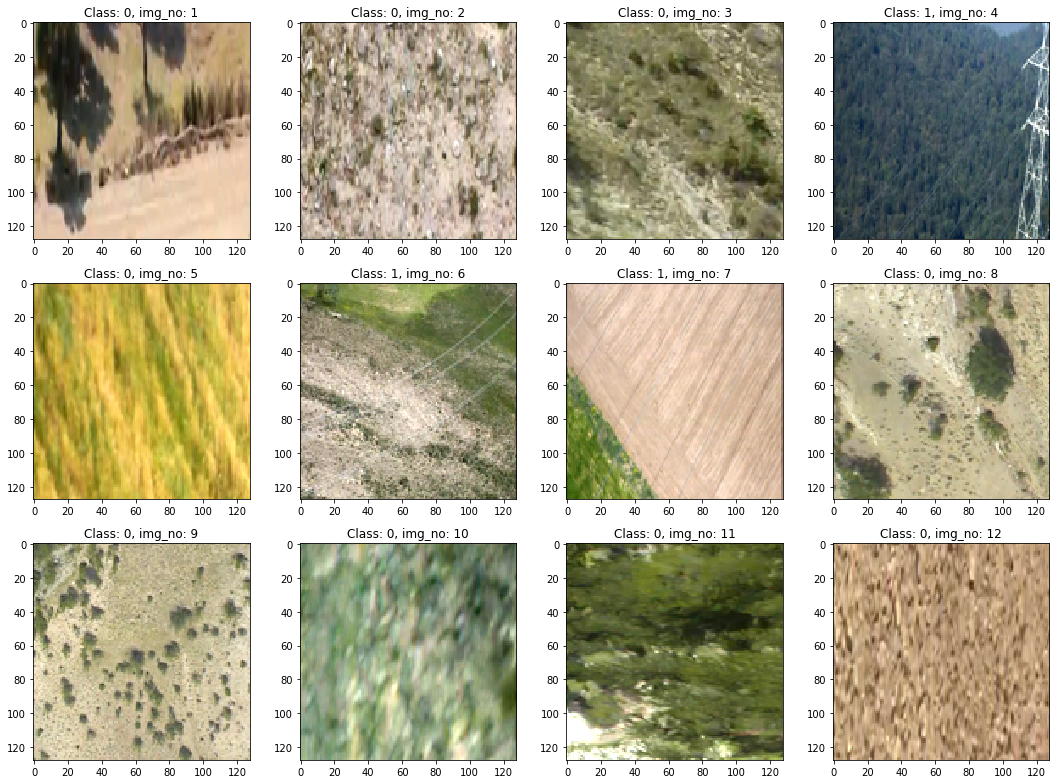

In [12]:
# Image brightening
datagen = ImageDataGenerator(brightness_range=[1,1.2])
augmentation(datagen)

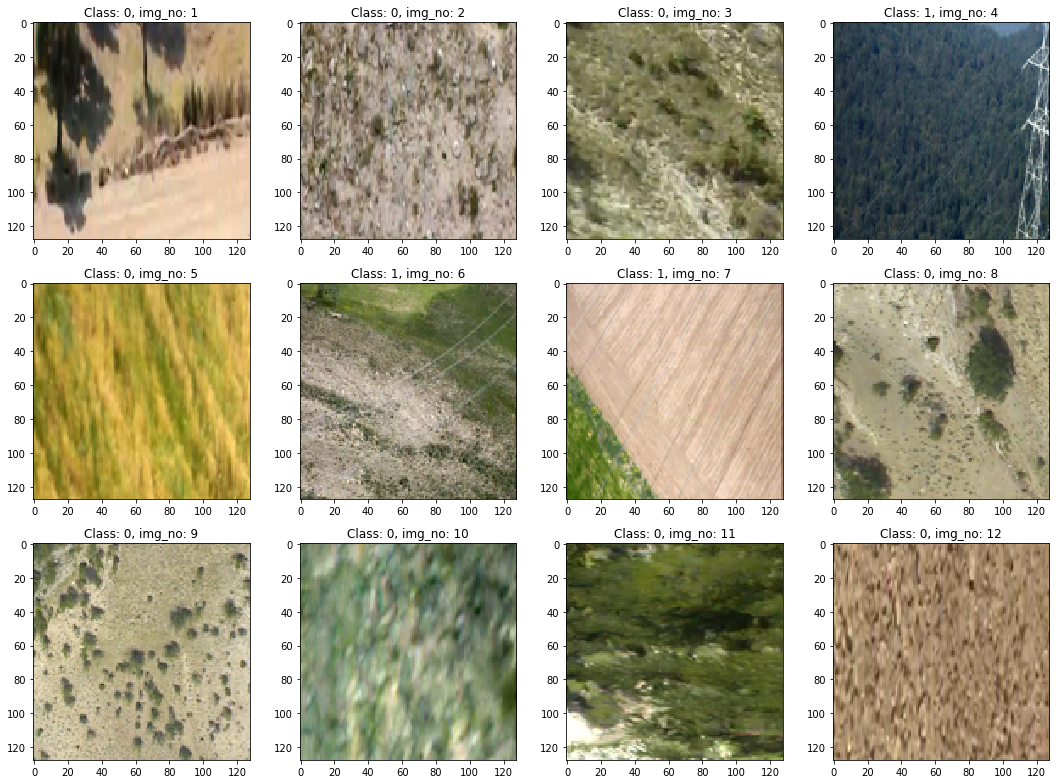

In [13]:
#Image darkening
datagen = ImageDataGenerator(brightness_range=[0.2,1])
augmentation(datagen)

# Saving Augmented Images to File in the flow

The data preparation and augmentation is performed just in time by Keras.
This is efficient in terms of memory, but you may require the exact images used during training. For example, perhaps you would like to use them with a different software package later or only generate them once and use them on multiple different deep learning models or configurations.

Keras allows you to save the images generated during training. The directory, filename prefix and image file type can be specified to the flow() function before training. Then, during training, the generated images will be written to file.

In [ ]:
# Define data preparation
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# Fit parameters from data
datagen.fit(X_train)

# Configure batch size and retrive one batch of images
os.makedirs('images')
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size = 12,shuffle=False, save_to_dir='images', save_prefix='aug', save_format='jpg'):
    # create a grid of 3x4 images
    plt.figure(figsize=(15,11))
    for idx in range(12):
        plt.subplot(3,4,idx+1)
        img = np.uint8(np.interp(X_batch[idx], (X_batch[idx].min(), X_batch[idx].max()), (0, 255)))
        plt.imshow(img)
        plt.title('Class: {}, img_no: {}'.format(y_batch[idx],(idx+1)))
    plt.tight_layout()
    break

# Save entire image dataset (after augmentation)

In [ ]:
# Define data preparation
datagen = ImageDataGenerator(featurewise_center=True, 
                             featurewise_std_normalization=True,
                             rotation_range=90,
                             width_shift_range=0.2, 
                             height_shift_range=0.2,
                             horizontal_flip=True, 
                             vertical_flip=True,
                             zoom_range=0.2,
                             brightness_range=[0.2,1.8]
                            )
# Fit parameters from data
datagen.fit(X_train)

# Configure batch size and retrive one batch of images
os.makedirs('images_2')
for X_batch, y_batch in datagen.flow(X_train, y_train, 
                                     batch_size = X_train.shape[0],
                                     shuffle=False, 
                                     save_to_dir='images_2', 
                                     save_prefix='aug_', 
                                     save_format='jpg'):
    break

# Data augmentation for training dataset

In [14]:
# Augmented datasets 
X_gen=[]
y_gen=[]
num_of_images = X_train.shape[0]

# Define augmentation parameters
datagen = ImageDataGenerator(rotation_range=90,
                             width_shift_range=0.2, 
                             height_shift_range=0.2,
                             horizontal_flip=True, 
                             vertical_flip=True,
                             zoom_range=0.2,
                             brightness_range=[0.8,1.2])

# Fit parameters from data
datagen.fit(X_train)

# Configure batch size and retrive one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size = num_of_images):
    for i in range(num_of_images):
        X_gen.append(X_batch[i])
        y_gen.append(y_batch[i])
    break

X_gen = np.array(X_gen)
y_gen = np.array(y_gen)
print(X_gen.shape, y_gen.shape)

(6390, 128, 128, 3) (6390,)


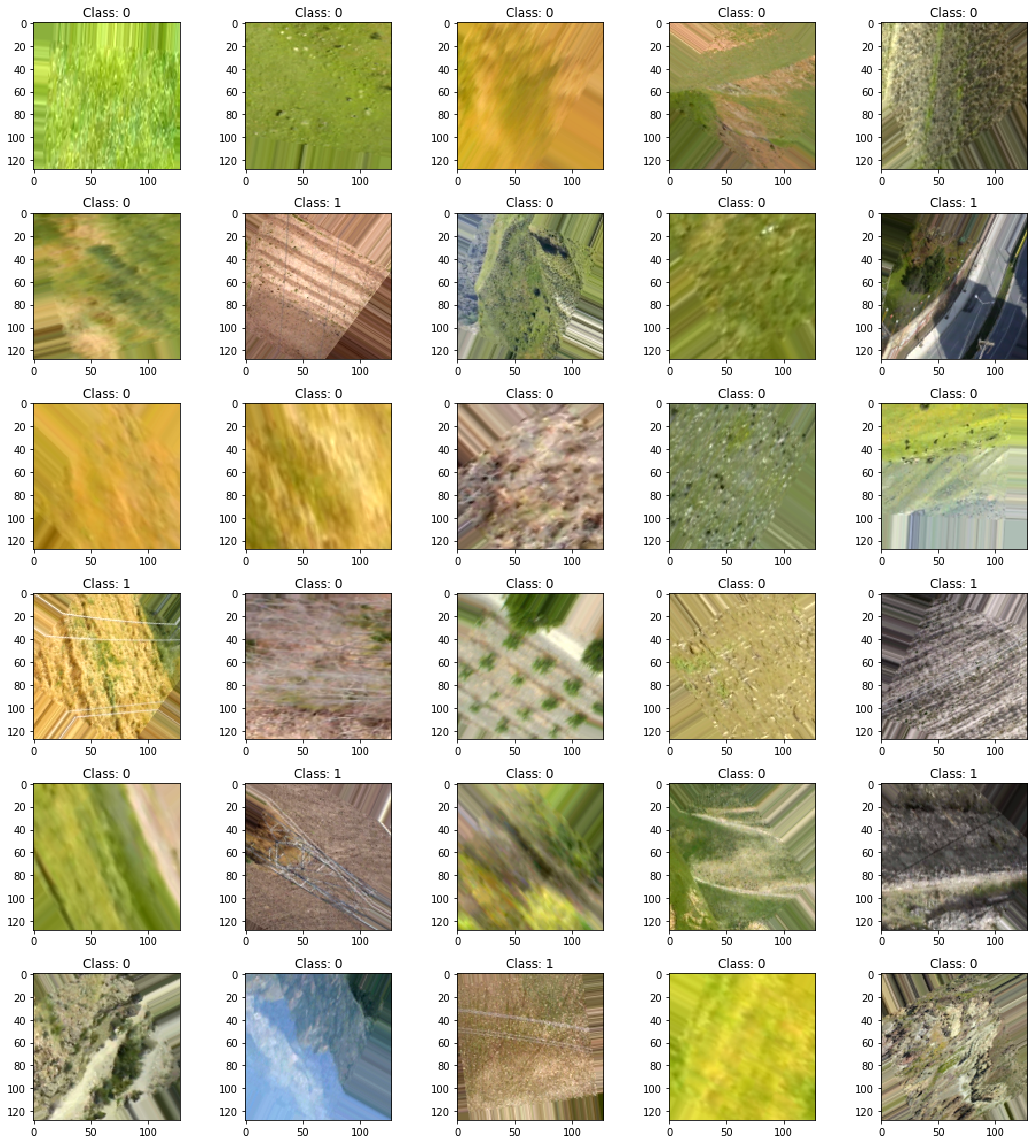

In [15]:
# Sample augmented data visualization
plt.figure(figsize=(15,16))
for idx in range(30):
    plt.subplot(6,5,idx+1)
    img = np.uint8(np.interp(X_gen[idx], (X_gen[idx].min(), X_gen[idx].max()), (0, 255)))
    plt.imshow(img)
    plt.title('Class: {}'.format(y_gen[idx]))
plt.tight_layout()